# Age Regression with Tensorflow Probability

In this notebook you will learn how work with TFP. You will set up regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution $p(y|x)$ as a Normal distribution first with a constant and second flexible standart deviation $\sigma$. As input data you will use images of faces and you will try to predict the conditional probability distribution of their age.

**Dataset:**
You work with a the [UTKFace dataset](https://susanqq.github.io/UTKFace/). It is a large dataset with a large age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprocessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age and image.

**Content:**
* Load and and split the dataset
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a constant standart deviation $\sigma$ .
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a flexible standart deviation $\sigma$ with TFP.

**GPU:**
It is better to use the GPU for this notebook. If you are using colab, you can change the runtime type in the menu: Runtime -> Change runtime type -> Hardware accelerator -> GPU.

**Your Task**
Steps through the notebook and try to understand the code. The code is already complete. At the end of the notebook you will find a little excecise, in which you should implement the NLL as a scoring rule and compares the two models.

In [34]:
EPOCHS = 20 # Change this to smaller number for testing, negative means load the weights from dropbox

In [35]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
tfd = tfp.distributions

In [36]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
print("np  Version",np.__version__)
print("EPOCHS",EPOCHS)

TFP Version 0.22.0
TF  Version 2.15.0
np  Version 1.23.5
EPOCHS 20


#### Loading the data, if it is not loaded

In [37]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")

In [38]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [40]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at a few image samples

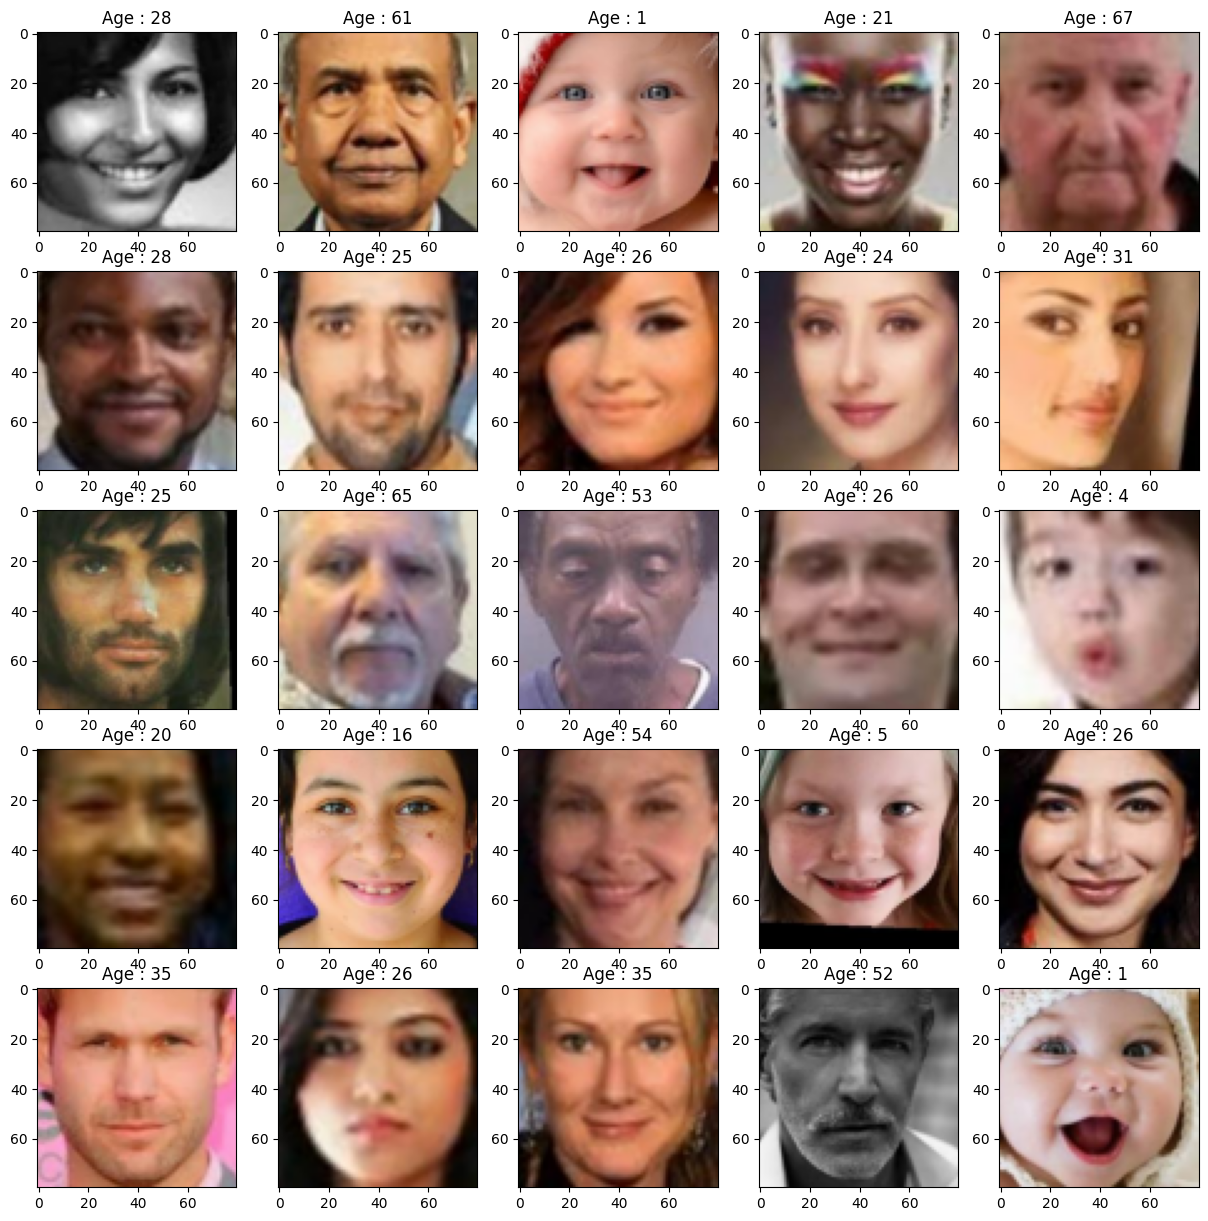

In [41]:
plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))

#### Normalize the data

In [42]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [43]:
#We only need float32
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

#### Looking at the age distribution

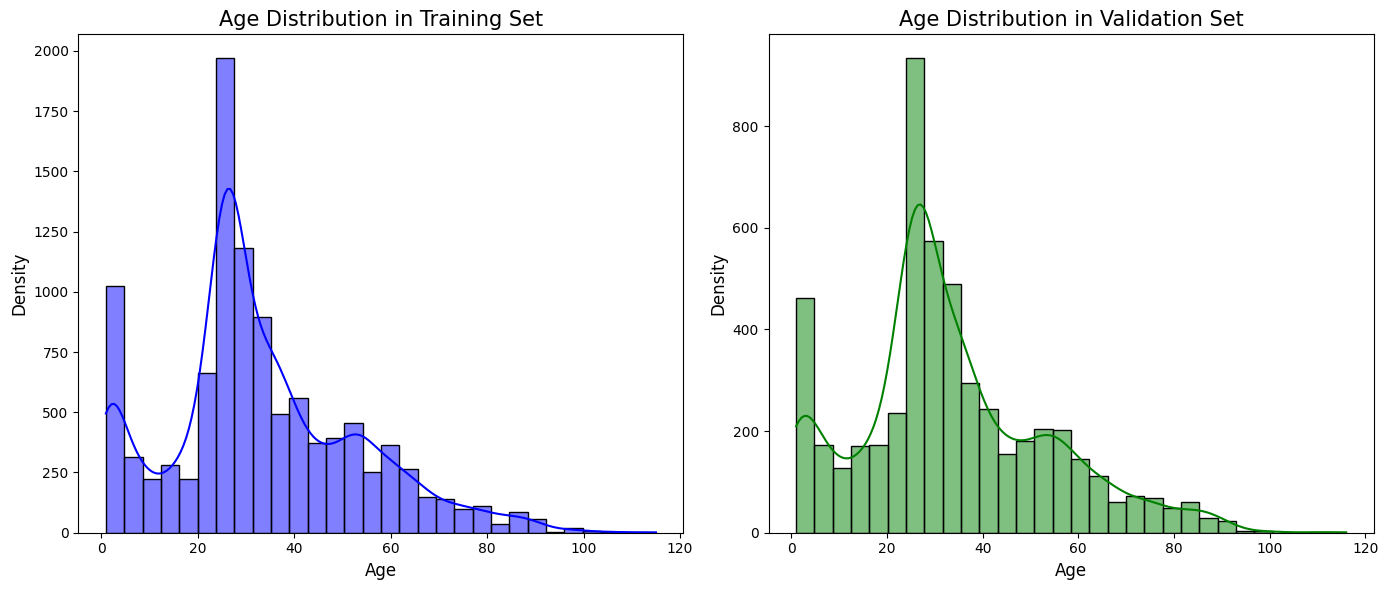

In [44]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(y_train, bins=30, kde=True, color='blue')
plt.title("Age Distribution in Training Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(1,2,2)
sns.histplot(y_val, bins=30, kde=True, color='green')
plt.title("Age Distribution in Validation Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

## Fit a regression model with constant variance
In the next cells you will define and fit a model on the face images. You will use a CNN to model the mu parameter of  a gaussian conditional probability distribution, the sigma will be constant for all inputs. For the loss we use the NLL.

In [45]:
#Create a layer that learns a global standard deviation
#This parameter will be a single scalar value representing the
#log of the std of the Gaussian distribution.
from tensorflow.keras.layers import Layer

class LearnableLogSD(Layer):
    def __init__(self, initial_value=0.0, **kwargs):
        super().__init__(**kwargs)
        self.log_sd = tf.Variable(initial_value=initial_value, trainable=True)

    def call(self, inputs):
        sd = tf.exp(self.log_sd)  # Exponentiate to get the actual sd
        return inputs, sd

In [46]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [47]:
def NLL(y, distr):
    return -distr.log_prob(y)

def my_dist_with_learnable_log_variance(params):
    mean, variance = params
    return tfd.Normal(loc=mean, scale=tf.sqrt(variance))  # scale should be std. deviation


input1 = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten()(x)
x = Dense(500, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.3)(x)
mean_predictions = Dense(1)(x)

log_variance_layer = LearnableLogSD(initial_value=10.0)
mean_and_log_variance = log_variance_layer(mean_predictions)
dist = tfp.layers.DistributionLambda(my_dist_with_learnable_log_variance)(mean_and_log_variance)

model_const_sd = Model(inputs=input1, outputs=dist)

model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL)

In [48]:
print(X_train[1:2].shape)
p_y_given_x = model_const_sd(X_train[1:2])
print(p_y_given_x.mean())
print(p_y_given_x.stddev())


(1, 80, 80, 3)
tf.Tensor([[-0.02895807]], shape=(1, 1), dtype=float32)
tf.Tensor([[148.41316]], shape=(1, 1), dtype=float32)


### Training the model

If you don't have a GPU, this will take a while. You can download the weights

Epoch 1/20
666/666 [==============================] - 9s 10ms/step - loss: 5.7672 - val_loss: 5.6043
Epoch 2/20
666/666 [==============================] - 6s 8ms/step - loss: 5.4398 - val_loss: 5.2767
Epoch 3/20
666/666 [==============================] - 6s 8ms/step - loss: 5.1179 - val_loss: 4.9553
Epoch 4/20
666/666 [==============================] - 7s 11ms/step - loss: 4.8069 - val_loss: 4.6476
Epoch 5/20
666/666 [==============================] - 6s 9ms/step - loss: 4.5125 - val_loss: 4.3600
Epoch 6/20
666/666 [==============================] - 5s 8ms/step - loss: 4.2528 - val_loss: 4.1515
Epoch 7/20
666/666 [==============================] - 6s 9ms/step - loss: 4.0428 - val_loss: 3.9349
Epoch 8/20
666/666 [==============================] - 6s 9ms/step - loss: 3.8949 - val_loss: 3.8408
Epoch 9/20
666/666 [==============================] - 6s 9ms/step - loss: 3.7987 - val_loss: 3.8498
Epoch 10/20
666/666 [==============================] - 6s 9ms/step - loss: 3.7397 - val_loss: 3.72

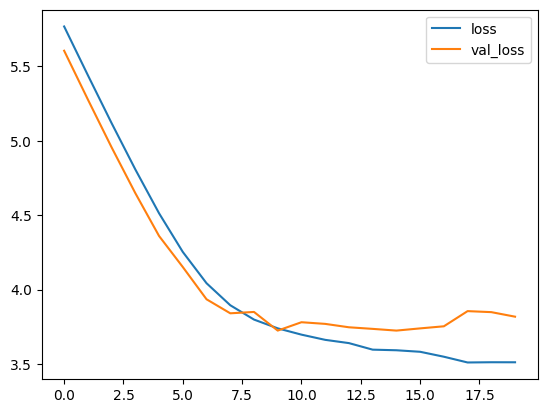

In [49]:
# train the model
if (EPOCHS > 0):
  history=model_const_sd.fit(X_train, y_train,
                      batch_size=16,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_data=(X_val, y_val)
                    )
  #model_const_sd.save_weights('model_const_sd.h5')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
else:
  import requests
  # Define the URL and the local file path
  url = 'https://www.dropbox.com/scl/fi/ojah3hqlltqn9wjyzboo9/model_const_sd.h5?rlkey=k4ahfellixhmokklxzlacrxp9&dl=1'
  local_file = 'model_const_sd.h5'

  # Check if the file already exists, if not download it
  if not os.path.exists(local_file):
      # Download the file if it does not exist
      response = requests.get(url)
      with open(local_file, 'wb') as f:
          f.write(response.content)

  # Load the weights from the local file
  model_const_sd.load_weights(local_file)

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


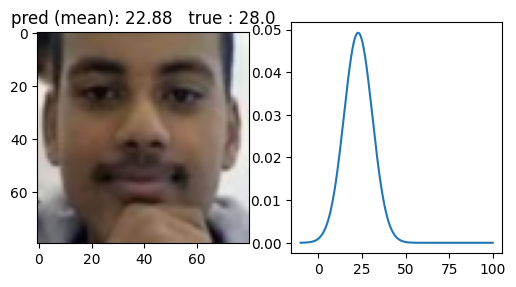

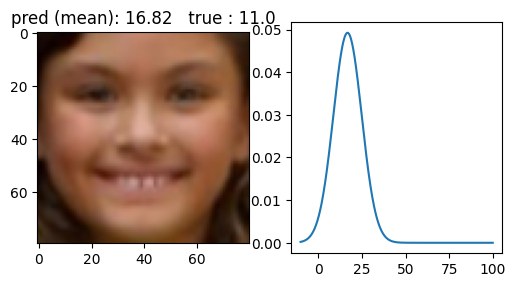

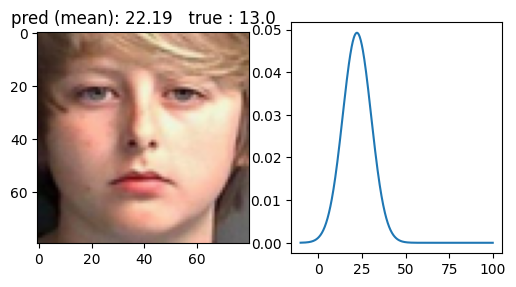

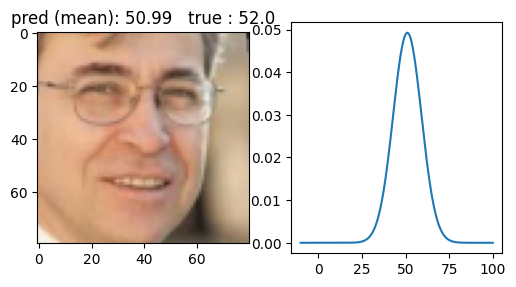

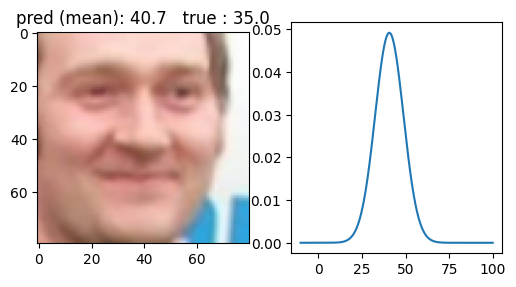

In [50]:
for i in range(0,5):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu = model_const_sd(X_test[i:i+1]).mean()
    sigma = model_const_sd(X_test[i:i+1]).stddev()
    #print(mu)
    #print(sigma)

    plt.title("pred (mean): "+ str(round(float(mu), 2)) +
            "   true : "+ str(y_test[i]))
    d = tfd.Normal(loc=mu, scale=sigma)           #A
    plt.subplot(1,2,2)
    plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
    plt.show()

## Fit a regression model with felxible variance
In the next cells you will again define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [51]:
def NLL(y, distr):
    return -distr.log_prob(y)

def my_dist(params):
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x)

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL)


Epoch 1/20
666/666 [==============================] - 9s 10ms/step - loss: 16.2006 - val_loss: 4.5684
Epoch 2/20
666/666 [==============================] - 7s 10ms/step - loss: 4.7370 - val_loss: 4.5319
Epoch 3/20
666/666 [==============================] - 5s 8ms/step - loss: 4.6314 - val_loss: 4.4413
Epoch 4/20
666/666 [==============================] - 6s 9ms/step - loss: 4.5898 - val_loss: 4.5093
Epoch 5/20
666/666 [==============================] - 6s 9ms/step - loss: 4.5637 - val_loss: 4.8688
Epoch 6/20
666/666 [==============================] - 6s 9ms/step - loss: 4.5569 - val_loss: 4.4007
Epoch 7/20
666/666 [==============================] - 6s 8ms/step - loss: 4.5121 - val_loss: 4.3427
Epoch 8/20
666/666 [==============================] - 5s 8ms/step - loss: 4.4661 - val_loss: 4.3831
Epoch 9/20
666/666 [==============================] - 5s 8ms/step - loss: 4.4867 - val_loss: 4.2595
Epoch 10/20
666/666 [==============================] - 5s 8ms/step - loss: 4.4244 - val_loss: 4.2

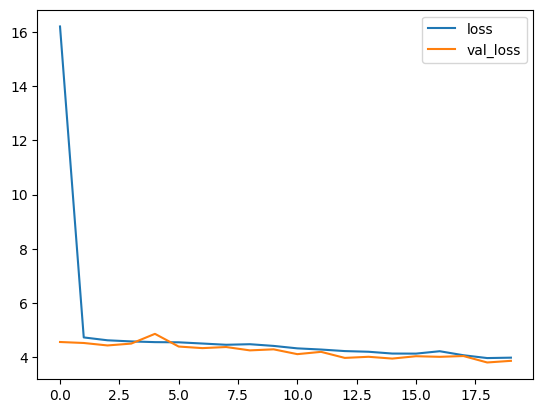

In [52]:
if (EPOCHS > 0):
  history=model_flex.fit(X_train, np.array(y_train,dtype="float32"),
                      batch_size=16,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_data=(X_val, np.array(y_val,dtype="float32"))
                    )
  #model_flex.save_weights('model_flex.h5')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
else:
    import requests
    # Define the URL and the local file path
    url = 'https://www.dropbox.com/scl/fi/3iucsr5rhojdq388jrovk/model_flex.h5?rlkey=8m8wbiiudftjgxuou4fkpz6u4&dl=1'
    local_file = 'model_flex.h5'

    # Check if the file already exists
    if not os.path.exists(local_file):
        # Download the file if it does not exist
        response = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(response.content)

    # Load the weights from the local file
    model_flex.load_weights(local_file)

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


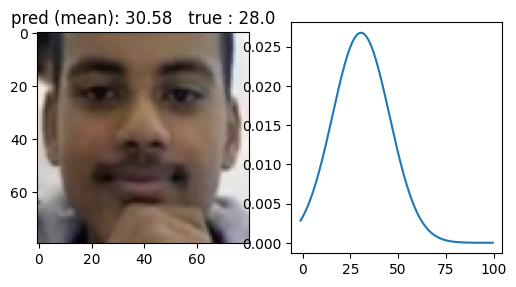

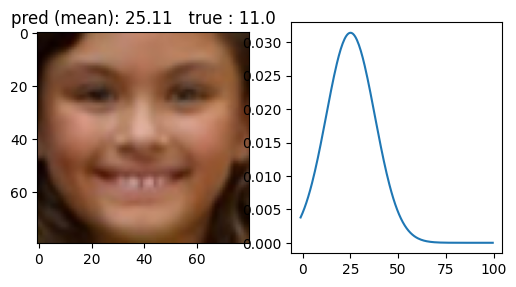

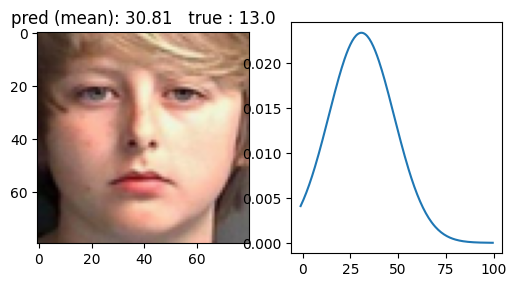

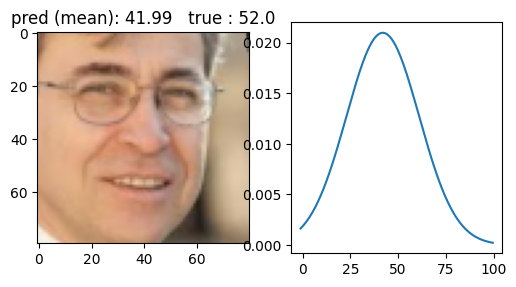

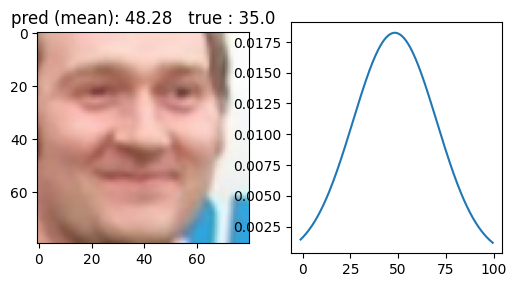

In [53]:
ages = np.arange(-1,100,0.5)

for i in range(0,5):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])
    mu = model_flex(X_test[i:i+1]).mean()
    sigma = model_flex(X_test[i:i+1]).stddev()
    #print(mu)
    #print(sigma)
    plt.title("pred (mean): "+ str(round(float(mu),2)) + "   true : "+ str(y_test[i]))
    ds = model_flex(X_test[i:i+1]).log_prob(ages)
    plt.subplot(1,2,2)
    plt.plot(ages, np.exp(ds)[0])
    plt.show()

# Exercise 1 (Compare the models)

Calculate the NLL for both models on the testset. For that write a function that has the API of a score. The function should take the observed/true `y_observed` values and the predicted CPD $p_{\tt{pred}}(y|x)$ as input (called `py_given_x`) and return the NLL. Here is the core of the function:

```python
def score(py_given_x, y_observed):
    # py_given_x: the predicted CPD as a tfp.distributions object
    # y_observed: the observed/true values
    # return: Score (lower is better forecast)
    # YOUR CODE HERE
```

Which model would you prefer in practice and why? Which other scores/metrics could you use to compare the models, which once should you not use?

In [54]:
def score(py_given_x, y_observed):
    # py_given_x: the predicted CPD as a tfp.distributions object
    # y_observed: the observed/true values
    # return: Score (lower is better forecast)
    # YOUR CODE HERE

    distribution = tfp.distributions.Normal(loc=py_given_x.mean(), scale=py_given_x.std())
    return -tf.reduce_mean(distribution.log_prob(y_observed))

const_dist = model_const_sd.predict(X_test)
flex_dist = model_flex.predict(X_test)

model_const_sd_score = score(const_dist, y_test)
model_flex_score = score(flex_dist, y_test)

print(model_const_sd_score)
print(model_flex_score)

245/245 [==============================] - 1s 4ms/step
tf.Tensor(4.411154, shape=(), dtype=float32)
tf.Tensor(4.4199896, shape=(), dtype=float32)


# Exercise 2
Find the 5 person of the test set the model is most certain about and plot the together with the predicted CPD.

In [55]:
# Calculate NLL for each instance
score_values_const = []
for i in range(len(X_test)):
    score_values_const.append(score(y_test[i], const_dist[i]).numpy())

score_values_flex = []
for i in range(len(X_test)):
    score_values_flex.append(score(y_test[i], flex_dist[i]).numpy())


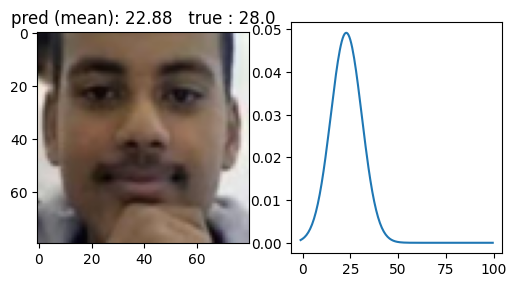

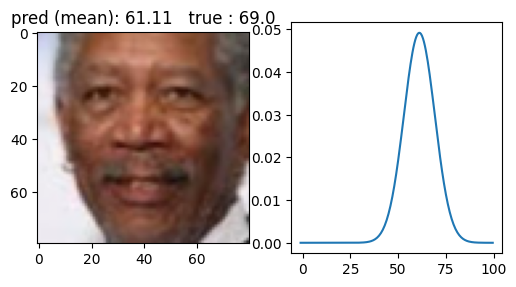

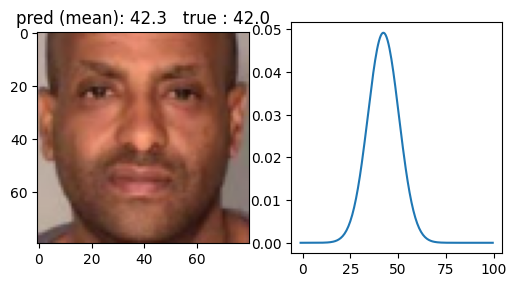

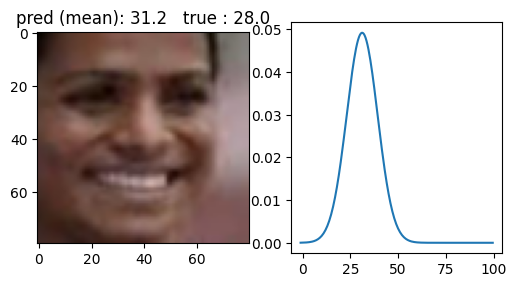

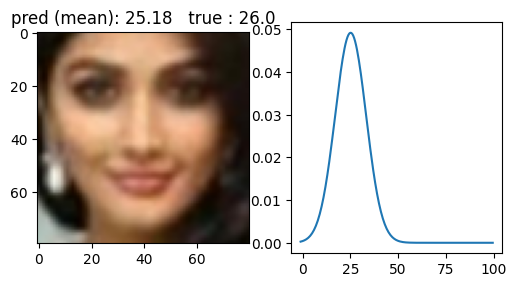

In [56]:
most_certain_const = np.argsort(score_values_const)[:5]

# Plot the instances and their predicted CPD
for idx in most_certain_const:

    i = idx

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])
    mu = model_const_sd(X_test[i:i+1]).mean()
    sigma = model_const_sd(X_test[i:i+1]).stddev()
    #print(mu)
    #print(sigma)
    plt.title("pred (mean): "+ str(round(float(mu),2)) + "   true : "+ str(y_test[i]))
    ds = model_const_sd(X_test[i:i+1]).log_prob(ages)
    plt.subplot(1,2,2)
    plt.plot(ages, np.exp(ds)[0])
    plt.show()

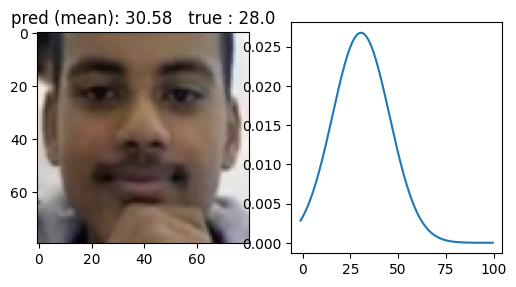

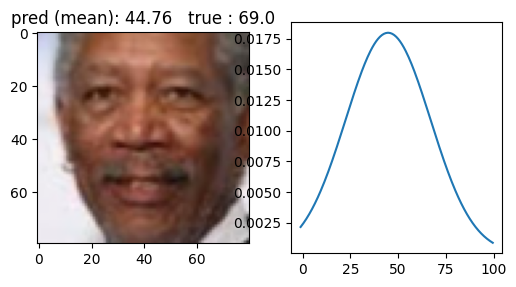

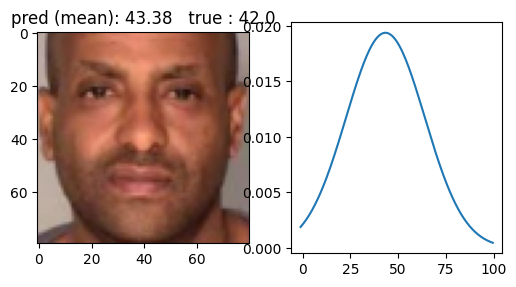

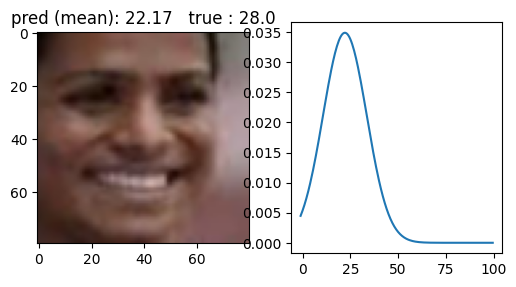

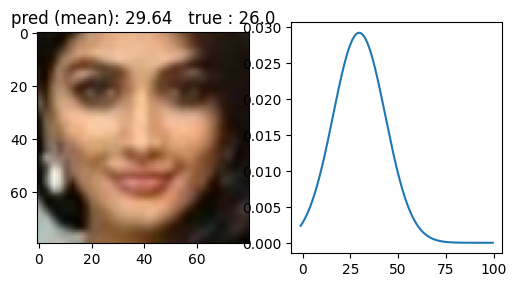

In [57]:
most_certain_flex = np.argsort(score_values_flex)[:5]

# Plot the instances and their predicted CPD
for idx in most_certain_flex:

    i = idx

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])
    mu = model_flex(X_test[i:i+1]).mean()
    sigma = model_flex(X_test[i:i+1]).stddev()
    #print(mu)
    #print(sigma)
    plt.title("pred (mean): "+ str(round(float(mu),2)) + "   true : "+ str(y_test[i]))
    ds = model_flex(X_test[i:i+1]).log_prob(ages)
    plt.subplot(1,2,2)
    plt.plot(ages, np.exp(ds)[0])
    plt.show()